In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm


titlesize = 24
labelsize = 22
legendsize = 22
xticksize = 18
yticksize = xticksize

plt.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
plt.rcParams['legend.handletextpad'] = 0.5
plt.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
plt.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
plt.rcParams['font.size'] = 12
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['axes.labelsize'] = labelsize
plt.rcParams['axes.titlesize'] = titlesize
plt.rcParams['figure.figsize'] = (10, 8)

plt.rc('xtick', labelsize=xticksize)
plt.rc('ytick', labelsize=yticksize)
plt.rc('legend', fontsize=legendsize)

In [2]:
def get_df_users(num_users=10000, prob_gender=0.6, min_age=20, max_age=60):

    user_id = np.random.default_rng().choice(89999, size=num_users, replace=False) + 10000
    gender = stats.bernoulli(p=prob_gender).rvs(size=num_users)
    age = np.random.uniform(min_age, max_age, size=num_users)

    df_users = pd.DataFrame({'user_id': user_id, 'gender': gender, 'age': age})
    df_users = df_users.astype(int)
    return df_users

In [3]:
def get_test(df_with_user_id, half_size):
    remaining_users = set(df_with_user_id.user_id.unique())

    group_a_one = np.random.choice(list(remaining_users), replace=False, size=half_size)
    remaining_users = remaining_users - set(group_a_one)

    group_a_two = np.random.choice(list(remaining_users), replace=False, size=half_size)
    remaining_users = remaining_users - set(group_a_two)

    group_b = np.random.choice(list(remaining_users), replace=False, size=half_size*2)
    remaining_users = remaining_users - set(group_b)

    test = {'group_a_one': list(group_a_one), 'group_a_two': list(group_a_two), 'group_b': list(group_b)}
    
    return test

In [4]:
def get_df_sales(user_id, num_sales, mu, std, days_range=(0, 56)):
    user_id_sales = np.random.choice(user_id, replace=True, size=num_sales)
    day = np.random.choice(np.arange(*days_range), replace=True, size=num_sales)
    sales = np.abs(np.random.normal(mu, std, size=num_sales).round(2))
    
    return pd.DataFrame({'user_id': user_id_sales, 'day': day, 'sales': sales})

In [5]:
# half_size = 1000
# mu_a1 = mu_a2 = 500
# std_a1 = std_a2 = 300
# mu_b = 600
# std_b = 300

# df_users = get_df_users()

# test = get_test(df_users, half_size)

# df_sales_a1 = get_df_sales(test['group_a_one'], num_sales=half_size, mu=mu_a1, std=std_a1)
# df_sales_a2 = get_df_sales(test['group_a_two'], num_sales=half_size, mu=mu_a2, std=std_a2)
# df_sales_b = get_df_sales(test['group_b'], num_sales=2*half_size, mu=mu_b, std=std_b)

# sales_df = pd.concat((df_sales_a1, df_sales_a2, df_sales_b), axis=0, ignore_index=True)

# END

In [6]:
def plot_pvalue_ecdf(pvalues, title=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if title:
        plt.suptitle(title)

    sns.histplot(pvalues, ax=ax1, bins=20, stat='density')
    ax1.plot([0,1],[1,1], 'k--')
    ax1.set_xlabel('p-value')
    ax1.set_xticks(np.arange(0,1.1, 0.2), minor=False)
    ax1.set_xlim((0,1))

    sns.ecdfplot(pvalues, ax=ax2)
    ax2.set_ylabel('Probability')
    ax2.set_xlabel('p-value')
    ax2.grid()
    ax2.set_xticks(np.arange(0,1.1, 0.2), minor=False)
    ax2.set_yticks(np.arange(0,1.1, 0.2), minor=False)
    ax2.set_xlim((0,1))

In [7]:
def _check_test(test, df_sales, df_users):
    group_a_one = test['group_a_one']
    group_a_two = test['group_a_two']
    group_b = test['group_b']
    
    p_val_aa, point_diff_aa = check_two_groups(df_sales, df_users, group_a_one, group_a_two)

    user_a = group_a_one + group_a_two
    user_b = group_b

    p_val_ab, point_diff_ab = check_two_groups(df_sales, df_users, user_a, user_b)

    return p_val_aa, point_diff_aa, p_val_ab, point_diff_ab

#_check_test(test)

In [8]:
def run_experiments(num_experiments=1000, half_size=1000,
                    mu_a1=500, mu_a2=500,std_a1=300, std_a2=300,
                    mu_b=515, std_b=300, shift_b_mean=0,
                    df_users_params=None):

    p_vals_aa = []
    p_vals_ab = []
    point_diffs_aa = []
    point_diffs_ab = []

    for _ in tqdm(range(num_experiments)):
        df_users = get_df_users() if df_users_params is None else get_df_users(**df_users_params)

        test = get_test(df_users, half_size)

        df_sales_a1 = get_df_sales(test['group_a_one'], num_sales=half_size, mu=mu_a1, std=std_a1)
        df_sales_a2 = get_df_sales(test['group_a_two'], num_sales=half_size, mu=mu_a2, std=std_a2)
        df_sales_b = get_df_sales(test['group_b'], num_sales=2*half_size, mu=mu_b, std=std_b)
        df_sales_b['sales'] += shift_b_mean
        
        df_sales = pd.concat((df_sales_a1, df_sales_a2, df_sales_b), axis=0, ignore_index=True)
        
        df_users, df_sales = preprocess_df_users_sales(df_users, df_sales)

        p_val_aa, point_diff_aa, p_val_ab, point_diff_ab = _check_test(test, df_sales, df_users)
        p_vals_aa.append(p_val_aa)
        p_vals_ab.append(p_val_ab)
        point_diffs_aa.append(point_diff_aa)
        point_diffs_ab.append(point_diff_ab)
        
    return p_vals_aa, point_diffs_aa, p_vals_ab, point_diffs_ab

# EXPERIMETS (START)

In [9]:
def check_two_groups(df_sales, df_users, user_a, user_b):
    sales_a = df_sales[df_sales['user_id'].isin(user_a)]['sales'].values
    sales_b = df_sales[df_sales['user_id'].isin(user_b)]['sales'].values
    point_diff = sales_b.mean() - sales_a.mean()
    return stats.ttest_ind(sales_a, sales_b)[1], point_diff

def preprocess_df_users_sales(df_users, df_sales):
    df_sales = df_sales[df_sales['day'].isin(np.arange(49, 56))]
    return df_users, df_sales

In [10]:
num_experiments=10000
half_size=2000
mu_a1=mu_a2=500 
std_a1=std_a2=300
mu_b=mu_a1
std_b=300
shift_b_mean=15

# EXPERIMENTS (END)


# Significant AB: 1374/10000
# Significant AB (AA-adjusted): 1303/10000
# Point diff AB >= true_diff: 4985
# Point diff AA >= true_diff: 2699
# TP: 1347
# TP (AA-adjusted): 1276
# FP: 27
# FP (AA-adjusted): 27


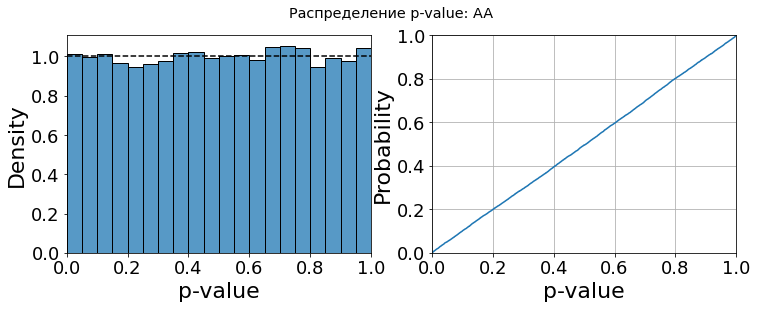

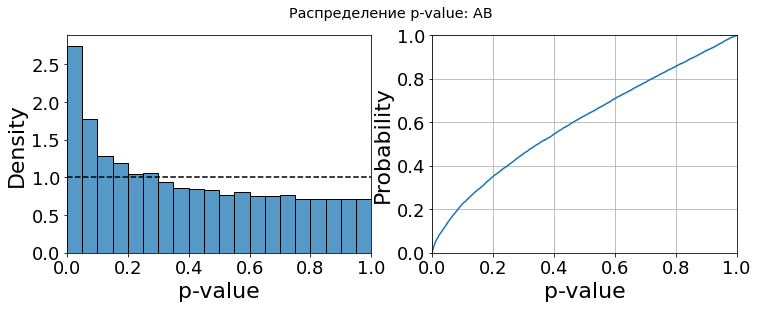

In [11]:
p_vals_aa, point_diffs_aa, p_vals_ab, point_diffs_ab = run_experiments(num_experiments=num_experiments, 
                                                                       half_size=half_size,
                                                                       mu_a1=mu_a1, 
                                                                       mu_a2=mu_a2,
                                                                       std_a1=std_a1, 
                                                                       std_a2=std_a2,
                                                                       mu_b=mu_b, 
                                                                       std_b=std_b,
                                                                       shift_b_mean=shift_b_mean)

plot_pvalue_ecdf(p_vals_aa, title='Распределение p-value: AA')
plot_pvalue_ecdf(p_vals_ab, title='Распределение p-value: AB')

significant_aa = np.array(p_vals_aa) < 0.05
significant_ab = np.array(p_vals_ab) < 0.05

significant_ab_but_not_aa = ((significant_ab).astype(int) - (significant_aa).astype(int)) == 1

print(f'# Significant AB: {significant_ab.sum()}/{num_experiments}')
print(f'# Significant AB (AA-adjusted): {significant_ab_but_not_aa.sum()}/{num_experiments}')

true_delta = mu_b + shift_b_mean - mu_a1
actual_effect_present = (np.array(point_diffs_ab) >= true_delta)

print(f'# Point diff AB >= true_diff: {actual_effect_present.sum()}')
print(f'# Point diff AA >= true_diff: {(np.array(point_diffs_aa) >= true_delta).sum()}')

print(f'# TP: {(actual_effect_present & significant_ab).sum()}')
print(f'# TP (AA-adjusted): {(actual_effect_present & significant_ab_but_not_aa).sum()}')

print(f'# FP: {(significant_ab & (~actual_effect_present)).sum()}')
print(f'# FP (AA-adjusted): {(significant_ab_but_not_aa & (~actual_effect_present)).sum()}')